# Astronomaly

This notebook is designed to replicate the feature extraction methods of Astronomaly. In addition, the steps are shown individually and explained in order to provide better detail in the processes of Astronomaly. The notebook would thus ideally serve as a troubleshooting method for Astronomaly.

________________

In [1]:
from astronomaly.base.base_pipeline import PipelineStage
from astronomaly.base import logging_tools
from astronomaly.data_management import image_reader
from astronomaly.preprocessing import image_preprocessing
from astronomaly.feature_extraction import power_spectrum, autoencoder
from astronomaly.feature_extraction import shape_features
from astronomaly.dimensionality_reduction import pca
from astronomaly.postprocessing import scaling
from astronomaly.anomaly_detection import isolation_forest, human_loop_learning
from astronomaly.visualisation import tsne
from astronomaly.utils import utils
from astropy.io import fits
from astronomaly.feature_extraction.shape_features import find_contours, fit_ellipse, draw_contour
from astronomaly.feature_extraction.shape_features import get_ellipse_leastsq, extract_contour

import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
image = '/home/verlon/Desktop/Astronomaly/Data/Coadd_0260/0260m062/Input/Failed Images/cutout_26.0835_-6.3682.fits'

In [3]:
image_data = fits.getdata(image)

In [4]:
image_data_g = image_data[0]
image_data_r = image_data[1]
image_data_z = image_data[2]

_____________

### Setting up the data

#### This section contains all of the relevant data and parameters that are to be specified in order for Astronomaly to run. 

In [5]:
coadd_id = '0260'  # Brick code

Some default settings for Astrnomaly to use on optical data

In [6]:
list_of_files = []
window_size = 32
band_prefixes = ['z-', 'r-', 'g-']
bands_rgb = {'r': 'z-', 'g': 'r-', 'b': 'g-'}
plot_cmap = 'hot'
feature_method = 'ellipse'
dim_reduction = ''

In [7]:
image_transform_function = [image_preprocessing.image_transform_sigma_clipping,
                            # image_preprocessing.image_transform_inverse_sinh,
                            image_preprocessing.image_transform_scale,
                            ]

display_transform_function = [# image_preprocessing.image_transform_inverse_sinh
                            image_preprocessing.image_transform_scale
                              ]

The data directory can be set up to shorten other directories and assists in sorting out the data storage. Due to the large number of bricks involved, it is much simpler to merely change the brick name than the entire directory all the time

In [8]:
data_dir = '/home/verlon/Desktop/Astronomaly/Data/Coadd_'+str(coadd_id)+'/'

In [9]:
image_dir = os.path.join(data_dir, '0260m062', 'Input', 'Images')
output_dir = os.path.join(data_dir, '0260m062', 'Output', '')

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [10]:
catalogue = pd.read_csv(os.path.join(data_dir,'0260m062','Input','test_catalogue_0260m062_500.csv'))

## Running Astronomaly

In [11]:
image_dataset = image_reader.ImageDataset(directory=image_dir,
                                          list_of_files=list_of_files,
                                          window_size=window_size,
                                          output_dir=output_dir,
                                          plot_square=False,
                                          transform_function=image_transform_function,
                                          display_transform_function=display_transform_function,
                                          plot_cmap=plot_cmap,
                                          catalogue=catalogue,
                                          band_prefixes=band_prefixes,
                                          bands_rgb=bands_rgb)

Reading image data from /home/verlon/Desktop/Astronomaly/Data/Coadd_0260/0260m062/Input/Images/z-legacysurvey-0260m062-image.fits.fz...


2020-10-12 19:01:53,014 - WARNING - FITSFixedWarning: 'datfix' made the change 'Set DATE-REF to '1858-11-17' from MJD-REF'.


Done!
A catalogue of  500 sources has been provided.


In [12]:
test = image_dataset.get_sample('66')

<function matplotlib.pyplot.show(close=None, block=None)>

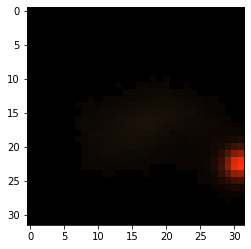

In [13]:
%matplotlib inline
plt.imshow(image_dataset.get_sample('66'))
plt.show

This function replicates the EllipseFitFeatures class and the contours and ellipses can be drawn from this.

In [14]:
def contours_and_ellipses(image_original, percentiles):

    ## Added this since the get_sample function returns multi-channel data
    image = cv2.cvtColor(image_original, cv2.COLOR_BGR2GRAY)
    
    ## This does not work
    #image = image_original[:, :, 0]

    x0 = y0 = -1
    x_cent = image.shape[0] // 2
    y_cent = image.shape[1] // 2

    feats = []
    all_contours = []
    all_ellipses = []
    all_parameters = []
    # Start with the closest in contour (highest percentile)
    percentiles = np.sort(percentiles)[::-1]

    if np.all(image == 0):
        failed = True
        failure_message = "Invalid cutout for feature extraction"
    else:
        failed = False
        failure_message = ""

    for p in percentiles:
        if failed:
            contours = []
        else:
            thresh = np.percentile(image[image > 0], p)
            contours, hierarchy = find_contours(image, thresh)

            x_contours = np.zeros(len(contours))
            y_contours = np.zeros(len(contours))

        # First attempt to find the central point of the inner most contour
        # if len(contours[0]) != 0:
        if len(contours) != 0:
            for k in range(len(contours)):
                M = cv2.moments(contours[k])
                try:
                    x_contours[k] = int(M["m10"] / M["m00"])
                    y_contours[k] = int(M["m01"] / M["m00"])
                except ZeroDivisionError:
                    pass
            if x0 == -1:
                x_diff = x_contours - x_cent
                y_diff = y_contours - y_cent
            else:
                x_diff = x_contours - x0
                y_diff = y_contours - y0

            # Will try to find the CLOSEST contour to the central one
            r_diff = np.sqrt(x_diff**2 + y_diff**2)

            ind = np.argmin(r_diff)

            if x0 == -1:
                x0 = x_contours[ind]
                y0 = y_contours[ind]

            c = contours[ind]

            params = get_ellipse_leastsq(c, image)
            # Params return in this order:
            # residual, x0, y0, maj_axis, min_axis, theta
            if np.any(np.isnan(params)):
                failed = True
            else:
                if params[3] == 0 or params[4] == 0:
                    aspect = 1
                else:
                    aspect = params[4] / params[3]

                if aspect < 1:
                    aspect = 1 / aspect
                if aspect > 100:
                    aspect = 1

                new_params = params[:3] + [aspect] + [params[-1]]
                feats.append(new_params)
        else:
            failed = True
            failure_message = "No contour found"

        if failed:
            feats.append([np.nan] * 5)
            logging_tools.log(failure_message)

        # Now we have the leastsq value, x0, y0, aspect_ratio, theta for each
        # sigma
        # Normalise things relative to the highest threshold value
        # If there were problems with any sigma levels, set all values to NaNs
        if np.any(np.isnan(feats)):
            return [np.nan] * 4 * len(percentiles)
        else:
            max_ind = np.argmax(percentiles)

            residuals = []
            dist_to_centre = []
            aspect = []
            theta = []

            x0_max_sigma = feats[max_ind][1]
            y0_max_sigma = feats[max_ind][2]
            aspect_max_sigma = feats[max_ind][3]
            theta_max_sigma = feats[max_ind][4]

            for n in range(len(feats)):
                prms = feats[n]
                residuals.append(prms[0])
                if prms[1] == 0 or prms[2] == 0:
                    r = 0
                else:
                    x_diff = prms[1] - x0_max_sigma
                    y_diff = prms[2] - y0_max_sigma
                    r = np.sqrt((x_diff)**2 + (y_diff)**2)
                dist_to_centre.append(r)
                aspect.append(prms[3] / aspect_max_sigma)
                theta_diff = np.abs(prms[4] - theta_max_sigma) % 360
                # Because there's redundancy about which way an ellipse
                # is aligned, we always take the acute angle
                if theta_diff > 90:
                    theta_diff -= 90
                theta.append(theta_diff)

            normalized_parameters = np.hstack(
                (residuals, dist_to_centre, aspect, theta))

        thickness = 1

        arr = image_original.copy()

        cnt = cv2.drawContours(arr, [c], 0, (1, 1, 1), thickness)

        ellipse_arr, params = fit_ellipse(
            c, image_original, return_params=True, filled=False)

        all_contours.append(cnt)
        all_ellipses.append(ellipse_arr)
        all_parameters.append(params)

    return (all_contours, all_ellipses, all_parameters)

In [15]:
percentiles = [90,80,70,60,50,0]

In [16]:
contours, ellipse, parameters = contours_and_ellipses(test, percentiles)

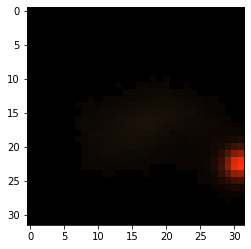

In [17]:
plt.imshow(test)

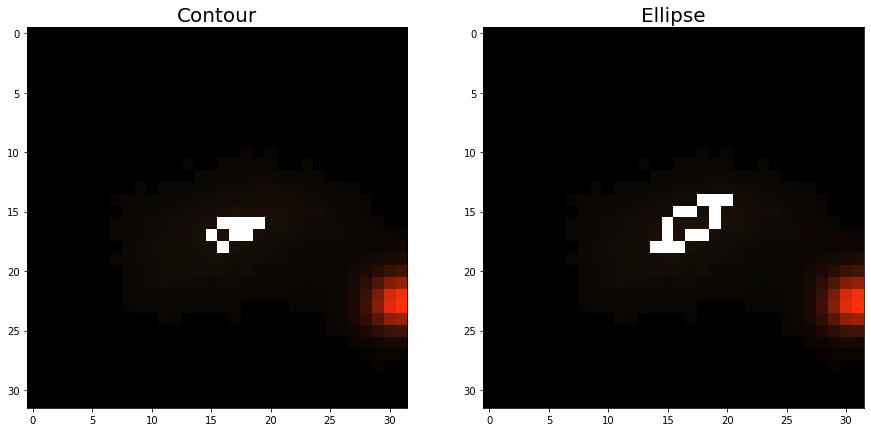

In [18]:
f = plt.figure(figsize = (15,15))

f.add_subplot(1,2, 1)
plt.imshow(contours[0])
plt.gca().set_title('Contour',fontsize = 20)

f.add_subplot(1,2, 2)
plt.imshow(ellipse[0])
plt.gca().set_title('Ellipse',fontsize = 20)
            
plt.show(block=True)

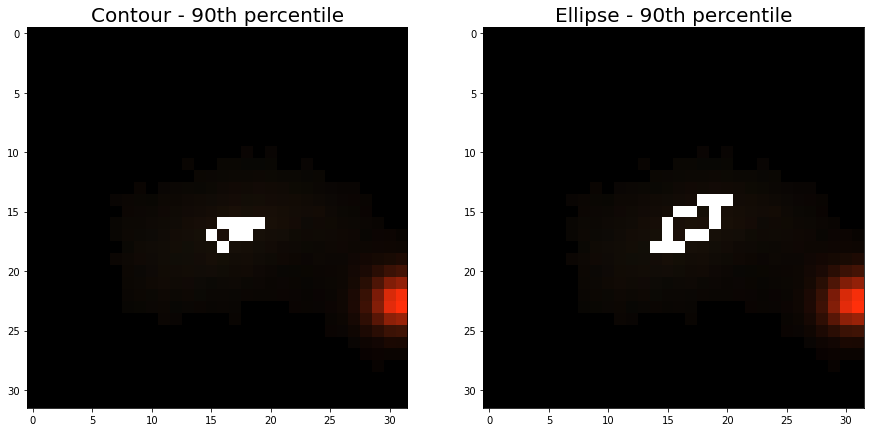

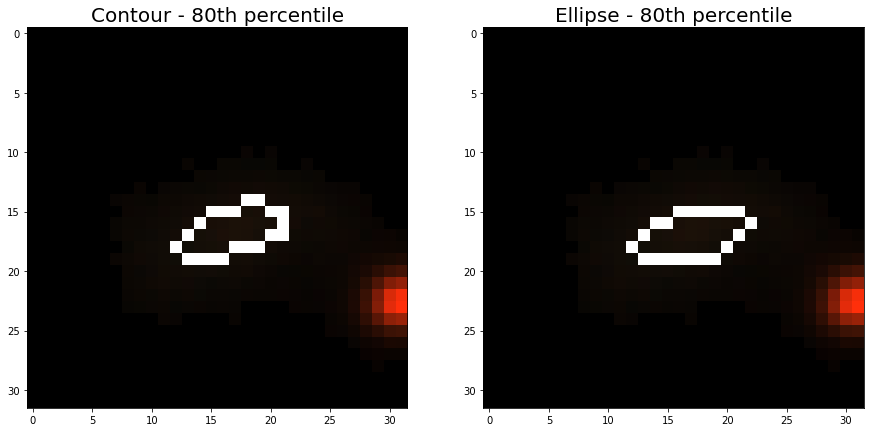

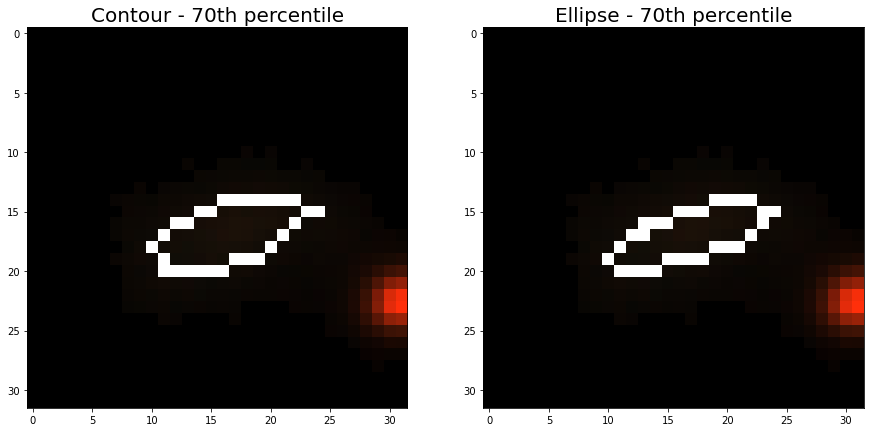

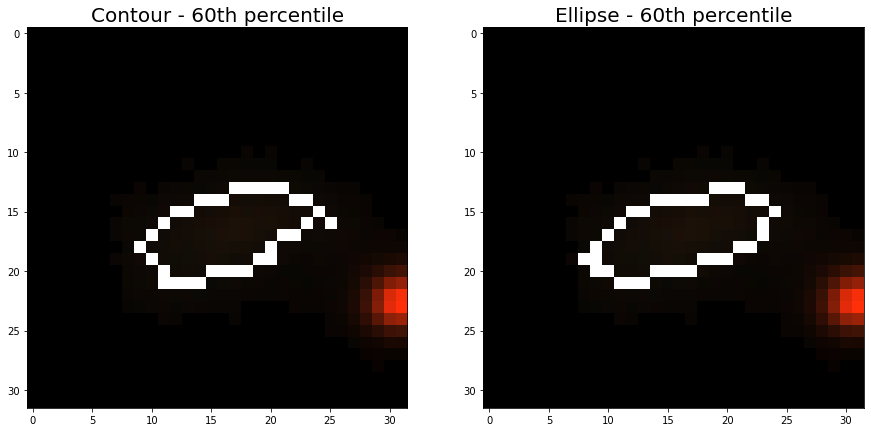

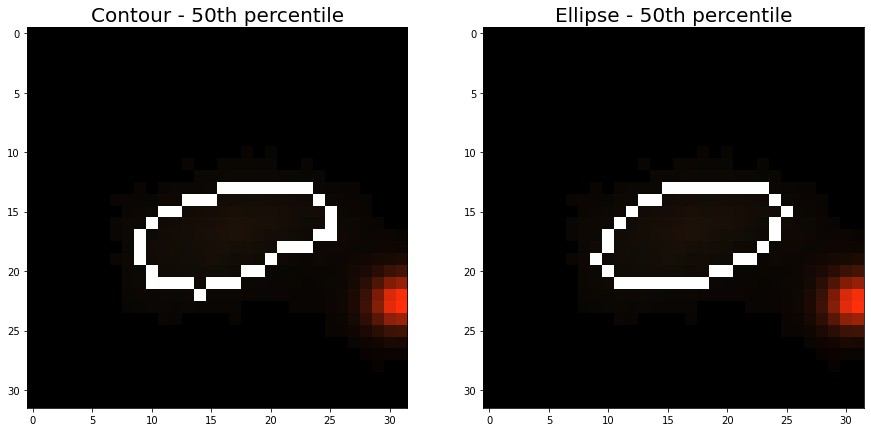

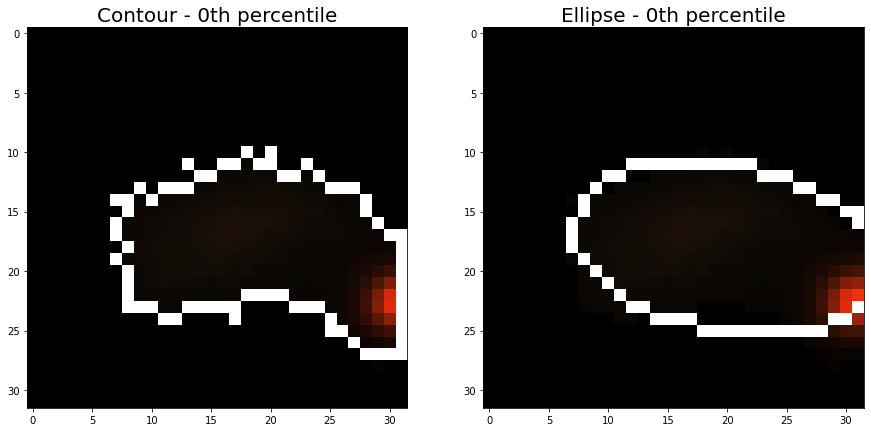

In [19]:
for p in range(len(percentiles)):
    
    f = plt.figure(figsize = (15,15))

    f.add_subplot(1,2, 1)
    plt.imshow(contours[p])
    plt.gca().set_title('Contour - ' +str(percentiles[p]) + 'th percentile',fontsize = 20)

    f.add_subplot(1,2, 2)
    plt.imshow(ellipse[p])
    plt.gca().set_title('Ellipse - ' +str(percentiles[p]) + 'th percentile',fontsize = 20)
            
    plt.show(block=True)

In [20]:
pipeline_ellipse = shape_features.EllipseFitFeatures(
    percentiles=[90, 80, 70, 60, 50, 0],
    output_dir=output_dir, channel=0, force_rerun=True
)

In [21]:
trial = test[:,:,0]
trial_ = trial.copy()

In [22]:
contours = []
threshold = []
for p in percentiles:
    thresh = np.percentile(trial[trial > 0], p)
    threshold.append(thresh)
    
for i in range(len(threshold)):
    contour, hierarchy = find_contours(trial, threshold[i])
    contours.append(contour)

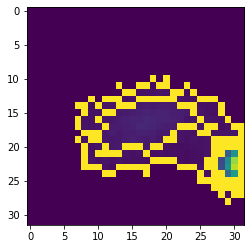

In [23]:
for p in range(len(contours)):
    draw = cv2.drawContours(trial_, contours[p], 0, (1, 1, 1), 1)
    plt.imshow(draw) #Does not return innermost contours as wanted

In [24]:
features_original = pipeline_ellipse.run_on_dataset(image_dataset)

Extracting features using EllipseFitFeatures ...
0 instances completed
100 instances completed
200 instances completed
300 instances completed
400 instances completed
Done! Time taken:  4.648221969604492 s


In [25]:
features_original

,Residual_90,Residual_80,Residual_70,Residual_60,Residual_50,Residual_0,Offset_90,Offset_80,Offset_70,Offset_60,...,Aspect_70,Aspect_60,Aspect_50,Aspect_0,Theta_90,Theta_80,Theta_70,Theta_60,Theta_50,Theta_0
594,0.006836,0.007812,0.005859,0.007812,0.012695,0.018555,0.0,0.047175,0.035994,0.155724,...,1.016166,1.115506,1.131660,1.189167,0.0,9.331472,10.269804,9.737352,10.002096,7.735697
6095,0.004883,0.006836,0.008789,0.009766,0.005859,0.031250,0.0,0.250177,0.387793,0.252793,...,0.983594,0.972603,0.901578,0.785001,0.0,11.276398,14.835693,17.968140,12.807770,3.069595
2709,0.006836,0.010742,0.009766,0.017578,0.026367,0.057617,0.0,0.312835,0.303631,0.199206,...,0.943308,1.018115,1.104370,1.192575,0.0,8.737560,36.054230,14.576263,37.101501,27.099213
5667,0.005859,0.009766,0.003906,0.009766,0.018555,0.015625,0.0,0.188332,0.000673,0.364915,...,1.365380,1.427257,1.371804,1.412971,0.0,7.823631,12.325592,7.853550,9.862442,15.180313
2471,0.009766,0.008789,0.009766,0.020508,0.012695,0.034180,0.0,0.128259,0.199350,0.205458,...,1.012938,1.063233,1.060496,1.005039,0.0,12.595322,0.827431,1.258385,3.053665,3.127861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6345,0.034180,0.033203,0.033203,0.033203,0.033203,0.033203,0.0,0.342117,0.342117,0.342117,...,0.872555,0.872555,0.872555,0.872555,0.0,3.223068,3.223068,3.223068,3.223068,3.223068
4612,0.029297,0.050781,0.050781,0.050781,0.050781,0.050781,0.0,0.604532,0.604532,0.604532,...,0.961432,0.961432,0.961432,0.961432,0.0,3.480148,3.480148,3.480148,3.480148,3.480148
2445,0.004883,0.096680,0.111328,0.111328,0.111328,0.111328,0.0,9.119883,8.006258,8.006258,...,1.577811,1.577811,1.577811,1.577811,0.0,12.074648,18.489325,18.489325,18.489325,18.489325
3190,0.031250,0.038086,0.038086,0.038086,0.038086,0.038086,0.0,0.773555,0.773555,0.773555,...,0.980157,0.980157,0.980157,0.980157,0.0,1.296585,1.296585,1.296585,1.296585,1.296585


In [26]:
features = features_original.copy()

In [27]:
features

,Residual_90,Residual_80,Residual_70,Residual_60,Residual_50,Residual_0,Offset_90,Offset_80,Offset_70,Offset_60,...,Aspect_70,Aspect_60,Aspect_50,Aspect_0,Theta_90,Theta_80,Theta_70,Theta_60,Theta_50,Theta_0
594,0.006836,0.007812,0.005859,0.007812,0.012695,0.018555,0.0,0.047175,0.035994,0.155724,...,1.016166,1.115506,1.131660,1.189167,0.0,9.331472,10.269804,9.737352,10.002096,7.735697
6095,0.004883,0.006836,0.008789,0.009766,0.005859,0.031250,0.0,0.250177,0.387793,0.252793,...,0.983594,0.972603,0.901578,0.785001,0.0,11.276398,14.835693,17.968140,12.807770,3.069595
2709,0.006836,0.010742,0.009766,0.017578,0.026367,0.057617,0.0,0.312835,0.303631,0.199206,...,0.943308,1.018115,1.104370,1.192575,0.0,8.737560,36.054230,14.576263,37.101501,27.099213
5667,0.005859,0.009766,0.003906,0.009766,0.018555,0.015625,0.0,0.188332,0.000673,0.364915,...,1.365380,1.427257,1.371804,1.412971,0.0,7.823631,12.325592,7.853550,9.862442,15.180313
2471,0.009766,0.008789,0.009766,0.020508,0.012695,0.034180,0.0,0.128259,0.199350,0.205458,...,1.012938,1.063233,1.060496,1.005039,0.0,12.595322,0.827431,1.258385,3.053665,3.127861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6345,0.034180,0.033203,0.033203,0.033203,0.033203,0.033203,0.0,0.342117,0.342117,0.342117,...,0.872555,0.872555,0.872555,0.872555,0.0,3.223068,3.223068,3.223068,3.223068,3.223068
4612,0.029297,0.050781,0.050781,0.050781,0.050781,0.050781,0.0,0.604532,0.604532,0.604532,...,0.961432,0.961432,0.961432,0.961432,0.0,3.480148,3.480148,3.480148,3.480148,3.480148
2445,0.004883,0.096680,0.111328,0.111328,0.111328,0.111328,0.0,9.119883,8.006258,8.006258,...,1.577811,1.577811,1.577811,1.577811,0.0,12.074648,18.489325,18.489325,18.489325,18.489325
3190,0.031250,0.038086,0.038086,0.038086,0.038086,0.038086,0.0,0.773555,0.773555,0.773555,...,0.980157,0.980157,0.980157,0.980157,0.0,1.296585,1.296585,1.296585,1.296585,1.296585


In [28]:
pipeline_scaler = scaling.FeatureScaler(force_rerun=True,
                                        output_dir=output_dir)
features = pipeline_scaler.run(features)

Running FeatureScaler ...
Done! Time taken: 0.01756763458251953 s


In [29]:
features

,Residual_90,Residual_80,Residual_70,Residual_60,Residual_50,Residual_0,Offset_90,Offset_80,Offset_70,Offset_60,...,Aspect_70,Aspect_60,Aspect_50,Aspect_0,Theta_90,Theta_80,Theta_70,Theta_60,Theta_50,Theta_0
594,-0.660322,-1.639257,-1.779901,-1.784644,-1.698251,-1.052571,0.0,-0.472954,-0.543741,-0.484274,...,-0.117165,0.265258,0.289946,0.484956,0.0,-0.513065,-0.482638,-0.520038,-0.506803,-0.612528
6095,-0.731904,-1.677982,-1.670701,-1.709603,-1.970697,-0.735207,0.0,-0.380042,-0.372977,-0.437499,...,-0.243525,-0.291482,-0.570455,-1.013402,0.0,-0.428056,-0.278797,-0.158362,-0.382936,-0.818050
2709,-0.660322,-1.523083,-1.634301,-1.409443,-1.153361,-0.076066,0.0,-0.351364,-0.413829,-0.463321,...,-0.399810,-0.114173,0.187895,0.497592,0.0,-0.539024,0.668492,-0.307408,0.689610,0.240350
5667,-0.696113,-1.561808,-1.852701,-1.709603,-1.464727,-1.125809,0.0,-0.408348,-0.560885,-0.383471,...,1.237582,1.479818,1.187980,1.314661,0.0,-0.578970,-0.390859,-0.602816,-0.512969,-0.284626
2471,-0.552947,-1.600533,-1.634301,-1.296882,-1.698251,-0.661969,0.0,-0.435843,-0.464447,-0.460308,...,-0.129686,0.061606,0.023825,-0.197658,0.0,-0.370409,-0.904187,-0.892620,-0.813570,-0.815483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6345,0.341837,-0.632413,-0.760700,-0.809121,-0.880916,-0.686382,0.0,-0.337962,-0.395148,-0.394456,...,-0.674290,-0.681262,-0.678988,-0.688813,0.0,-0.780052,-0.797236,-0.806288,-0.806091,-0.811290
4612,0.162880,0.064633,-0.105500,-0.133760,-0.180342,-0.246954,0.0,-0.217858,-0.267772,-0.268006,...,-0.329500,-0.335004,-0.346629,-0.359322,0.0,-0.768815,-0.785758,-0.794991,-0.794741,-0.799967
2445,-0.731904,1.884697,2.151301,2.192486,2.232745,1.266629,0.0,3.679535,3.325033,3.298678,...,2.061693,2.066367,1.958354,1.925770,0.0,-0.393166,-0.115683,-0.135461,-0.132100,-0.138878
3190,0.234463,-0.438789,-0.578700,-0.621521,-0.686312,-0.564319,0.0,-0.140497,-0.185728,-0.186558,...,-0.256859,-0.262054,-0.276607,-0.289904,0.0,-0.864255,-0.883242,-0.890941,-0.891143,-0.896143


In [30]:
pipeline_iforest = isolation_forest.IforestAlgorithm(
    force_rerun=True, output_dir=output_dir)
anomalies = pipeline_iforest.run(features)

Running IforestAlgorithm ...
Done! Time taken: 0.6861908435821533 s


In [31]:
pipeline_score_converter = human_loop_learning.ScoreConverter(
    force_rerun=False, output_dir=output_dir)
anomalies = pipeline_score_converter.run(anomalies)
anomalies = anomalies.sort_values('score', ascending=False)

Running ScoreConverter ...
Running anomaly score rescaler...
Done! Time taken: 0.008404731750488281 s


In [32]:
try:
    df = pd.read_csv(
        os.path.join(output_dir, 'ml_scores.csv'),
        index_col=0,
        dtype={'human_label': 'int'})
    df.index = df.index.astype('str')

    if len(anomalies) == len(df):
        anomalies = pd.concat(
            (anomalies, df['human_label']), axis=1, join='inner')
except FileNotFoundError:
    pass

pipeline_active_learning = human_loop_learning.NeighbourScore(
    alpha=1, output_dir=output_dir)

pipeline_tsne = tsne.TSNE_Plot(
    force_rerun=False,
    output_dir=output_dir,
    perplexity=50)
t_plot = pipeline_tsne.run(features.loc[anomalies.index])

Running TSNE_Plot ...
Done! Time taken: 5.333759069442749 s


In [33]:
image_dataset

In [34]:
features

,Residual_90,Residual_80,Residual_70,Residual_60,Residual_50,Residual_0,Offset_90,Offset_80,Offset_70,Offset_60,...,Aspect_70,Aspect_60,Aspect_50,Aspect_0,Theta_90,Theta_80,Theta_70,Theta_60,Theta_50,Theta_0
594,-0.660322,-1.639257,-1.779901,-1.784644,-1.698251,-1.052571,0.0,-0.472954,-0.543741,-0.484274,...,-0.117165,0.265258,0.289946,0.484956,0.0,-0.513065,-0.482638,-0.520038,-0.506803,-0.612528
6095,-0.731904,-1.677982,-1.670701,-1.709603,-1.970697,-0.735207,0.0,-0.380042,-0.372977,-0.437499,...,-0.243525,-0.291482,-0.570455,-1.013402,0.0,-0.428056,-0.278797,-0.158362,-0.382936,-0.818050
2709,-0.660322,-1.523083,-1.634301,-1.409443,-1.153361,-0.076066,0.0,-0.351364,-0.413829,-0.463321,...,-0.399810,-0.114173,0.187895,0.497592,0.0,-0.539024,0.668492,-0.307408,0.689610,0.240350
5667,-0.696113,-1.561808,-1.852701,-1.709603,-1.464727,-1.125809,0.0,-0.408348,-0.560885,-0.383471,...,1.237582,1.479818,1.187980,1.314661,0.0,-0.578970,-0.390859,-0.602816,-0.512969,-0.284626
2471,-0.552947,-1.600533,-1.634301,-1.296882,-1.698251,-0.661969,0.0,-0.435843,-0.464447,-0.460308,...,-0.129686,0.061606,0.023825,-0.197658,0.0,-0.370409,-0.904187,-0.892620,-0.813570,-0.815483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6345,0.341837,-0.632413,-0.760700,-0.809121,-0.880916,-0.686382,0.0,-0.337962,-0.395148,-0.394456,...,-0.674290,-0.681262,-0.678988,-0.688813,0.0,-0.780052,-0.797236,-0.806288,-0.806091,-0.811290
4612,0.162880,0.064633,-0.105500,-0.133760,-0.180342,-0.246954,0.0,-0.217858,-0.267772,-0.268006,...,-0.329500,-0.335004,-0.346629,-0.359322,0.0,-0.768815,-0.785758,-0.794991,-0.794741,-0.799967
2445,-0.731904,1.884697,2.151301,2.192486,2.232745,1.266629,0.0,3.679535,3.325033,3.298678,...,2.061693,2.066367,1.958354,1.925770,0.0,-0.393166,-0.115683,-0.135461,-0.132100,-0.138878
3190,0.234463,-0.438789,-0.578700,-0.621521,-0.686312,-0.564319,0.0,-0.140497,-0.185728,-0.186558,...,-0.256859,-0.262054,-0.276607,-0.289904,0.0,-0.864255,-0.883242,-0.890941,-0.891143,-0.896143


In [35]:
anomalies

,score
6542,5.000000
6701,4.522071
4638,4.399728
793,3.981926
6543,3.642077
...,...
1708,0.045200
7095,0.041851
4733,0.023170
3082,0.018148


In [36]:
t_plot

,0,1
6542,9.282928,9.585132
6701,-8.757014,8.917008
4638,-8.743892,8.899641
793,8.960543,8.835365
6543,-10.327025,-2.666218
...,...,...
1708,-0.298006,0.730780
7095,-0.585044,-3.706494
4733,0.566421,-3.747498
3082,1.958770,-6.817620


from astronomaly.frontend.image_pipeline import run_pipeline

astronomaly = run_pipeline()